In [1]:
# CHECK NUMBERS VERSION 

In [2]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb
import time
os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [106]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41929 instead
  warnings.warn(


In [107]:
cluster

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.135:38127,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load preprocessed Data

In [6]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [8]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s

upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


run_depths=False #Turn to false after proces
if run_depths==True:
    upwelling_cafe_100=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-100,method='nearest') #
    upwelling_cafe_300=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-300,method='nearest') #
    upwelling_cafe_500=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-500,method='nearest') #
    upwelling_cafe_600=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-600,method='nearest') #
    upwelling_cafe_900=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-900,method='nearest') #

    upwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups

    upwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups

    upwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups

    upwelling_600=(upwelling_cafe_600.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-600,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_600=(upwelling_cafe_600.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-600,method='nearest')*area_m2)#/1e6 # To Sverdrups

    upwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups
    print('Saving')
    upwelling_100.to_netcdf('../processed_data/upwelling_through_layers/upwelling100.nc')
    upwelling_300.to_netcdf('../processed_data/upwelling_through_layers/upwelling300.nc')
    upwelling_500.to_netcdf('../processed_data/upwelling_through_layers/upwelling500.nc')
    upwelling_600.to_netcdf('../processed_data/upwelling_through_layers/upwelling600.nc')
    upwelling_900.to_netcdf('../processed_data/upwelling_through_layers/upwelling900.nc')
    print('Saving2')
    anthupwelling_100.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling100.nc')
    anthupwelling_300.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling300.nc')
    anthupwelling_500.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling500.nc')
    anthupwelling_600.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling600.nc')
    anthupwelling_900.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling900.nc')

    
upwelling_100=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling100.nc').__xarray_dataarray_variable__
upwelling_300=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling300.nc').__xarray_dataarray_variable__
upwelling_500=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling500.nc').__xarray_dataarray_variable__
upwelling_600=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling600.nc').__xarray_dataarray_variable__
upwelling_900=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling900.nc').__xarray_dataarray_variable__
anthupwelling_100=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling100.nc').__xarray_dataarray_variable__
anthupwelling_300=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling300.nc').__xarray_dataarray_variable__
anthupwelling_500=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling500.nc').__xarray_dataarray_variable__
anthupwelling_600=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling600.nc').__xarray_dataarray_variable__
anthupwelling_900=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling900.nc').__xarray_dataarray_variable__

   

anthflux=((cafe_co2_anth*-1)*area_m2)#/1e6 # Or maybe 9? # To Sverdrups (Because skin not m3? I have no idea).
flux=((cafe_co2*-1)*area_m2)#/1e6 #Or mabe 9? To Sverdrups


# EVERYTHING SHOULD BE IN MMOL/S

## METHOD 1: Total Anth DIC change inside the box between 2000 and 2020

In [13]:
# Validation Budget
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_alldep1.nc').chunk('auto').__xarray_dataarray_variable__

st_ocean_holder=anth_dic_cafe.st_ocean

l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)

st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

# Multiply by Cell Depths
anth_dic_cafe=anth_dic_cafe*st_ocean_holder.depth_diff #Cell weighted depth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

tot_anth_dic_cafe=anth_dic_cafe*area_m2#/1000 #mol anthC (m3 is now cancelled)

In [155]:
area_m2

<xarray.DataArray 'area_t' (lat: 140, lon: 170)>
array([[9.285778e+09, 9.285778e+09, 9.285778e+09, ..., 9.285778e+09,
        9.285778e+09, 9.285778e+09],
       [9.467707e+09, 9.467707e+09, 9.467707e+09, ..., 9.467707e+09,
        9.467707e+09, 9.467707e+09],
       [9.643206e+09, 9.643206e+09, 9.643206e+09, ..., 9.643206e+09,
        9.643206e+09, 9.643206e+09],
       ...,
       [9.505625e+09, 9.505625e+09, 9.505625e+09, ..., 9.505625e+09,
        9.505625e+09, 9.505625e+09],
       [9.296072e+09, 9.296072e+09, 9.296072e+09, ..., 9.296072e+09,
        9.296072e+09, 9.296072e+09],
       [9.077938e+09, 9.077938e+09, 9.077938e+09, ..., 9.077938e+09,
        9.077938e+09, 9.077938e+09]], dtype=float32)
Coordinates:
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    long_name:  tracer cell area
    units:      m^2
    history:    From ocean_month_1500_01

In [156]:
tot_anth_dic_cafe.sel(time='2020-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,700),lon=slice(160,250)).sum().values

KeyboardInterrupt: 

# CHECK THE INVENTORY MAP

In [16]:
# CHECK CALCULATIONS

# Is the Amount of anth C accumulated in the box over the 20 years. (mmol anth C)
#tot_anth_dic_cafe=anth_dic_cafe*area_m2
diff=tot_anth_dic_cafe.sel(time='2020-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,600)).sum().values-\
    tot_anth_dic_cafe.sel(time='2000-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,600)).sum().values# Total mol anthC 

print((diff*12)/1e18) #Petagrams total change

#Total ADIC in the box
print((tot_anth_dic_cafe.sel(time='2020-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,600)).sum().values*12)/1e18)

# Calculate total DIC in the box at 2020-01-01 and 2020-01-01
# And then calculate total transport through each of the faces. 

print((tot_anth_dic_cafe.sel(time='2000-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,600)).sum().values*12)/1e18)

0.7844986296952589
2.820181403432956
2.0356827737376975


In [ ]:
# Is the Amount of anth C accumulated in the box over the 20 years. (mmol anth C)
#tot_anth_dic_cafe=anth_dic_cafe.chunk('auto')*area_m2.chunk('auto')/1000

## Method 2: Box Sums

In [17]:
#Calculate AnthC Box Total

anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s

adic_v_s=anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=slice(160,250)).sel(lat=-3,method='nearest')
dic_v_s=dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=slice(160,250)).sel(lat=-3,method='nearest')

adic_v_n=anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=slice(160,250)).sel(lat=3,method='nearest')
dic_v_n=dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=slice(160,250)).sel(lat=3,method='nearest')

adic_u_w=anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=160,method='nearest').sel(lat=slice(-3,3))
dic_u_w=dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=160,method='nearest').sel(lat=slice(-3,3))

adic_u_e=-anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=250,method='nearest').sel(lat=slice(-3,3))
dic_u_e=-dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=250,method='nearest').sel(lat=slice(-3,3))

up600=upwelling_600.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-3,3),lon=slice(160,250))
aup600=anthupwelling_600.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-3,3),lon=slice(160,250))

outsurf=flux.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-3,3),lon=slice(160,250))
aoutsurf=anthflux.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-3,3),lon=slice(160,250))

total_sum=adic_v_s.sum()+adic_v_n.sum()+adic_u_w.sum()+adic_u_e.sum()+aup600.sum()+aoutsurf.sum()
print(total_sum.values)
print((total_sum.values*60*60*24*(365/12)*12)/1e18) #mmolC /S /cell -> minute -> hour -> day -> month _> mgrams - > pgrams
# Doesnt line up with below number out by an order of mag or 2. 

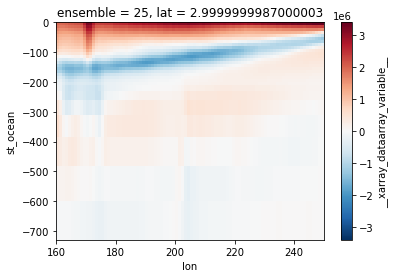

In [120]:
adic_v_n.mean(dim='time').plot()

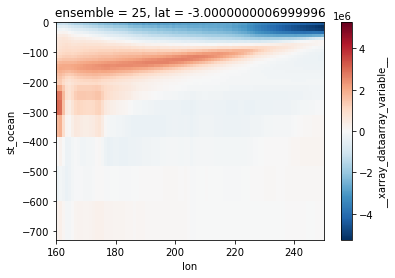

In [125]:
adic_v_s.mean(dim='time').plot()

In [143]:
# Values change significantly depending where the mean is taken!

In [143]:
(adic_v_s.sum().values*60*60*24*(365/12)*12)/1e18#.plot()

-0.468557443694592

In [141]:
(adic_v_s.where(adic_v_s>=0).sum().values*60*60*24*(365/12)*12)/1e18#.plot()

13.039044186341377

In [142]:
(adic_v_s.where(adic_v_s<0).sum().values*60*60*24*(365/12)*12)/1e18#.plot()

-13.507602792579071

In [146]:
(adic_v_s.mean(dim='time').where(adic_v_s.mean(dim='time')>=0).sum().values*60*60*24*365*20*12)/1e18#.plot()

9.3450397704192

In [148]:
(adic_v_s.mean(dim='time').where(adic_v_s.mean(dim='time')<0).sum().values*60*60*24*365*20*12)/1e18#.plot()

-9.81165357121536

In [149]:
(adic_v_s.where(adic_v_s<0).mean(dim='time').sum().values*60*60*24*365*20*12)/1e18#.plot()

-19.97229095682048

In [150]:
(adic_v_s.where(adic_v_s>=0).mean(dim='time').sum().values*60*60*24*365*20*12)/1e18#.plot()

20.67959380672512

In [153]:
13.03+-13.507

In [154]:
20.679+-19.97

0.7089999999999996

In [136]:
20.6795938067251+-19.972290956

0.7073028507251031

In [129]:
(adic_v_s.mean(dim='time').sum().values*60*60*24*365*20*12)/1e18#.plot()

-0.46661283201024

In [132]:
(adic_v_s.sum().values*60*60*24*30*12)/1e18#.plot()

-0.462138848575488

In [ ]:
365/12

In [118]:
adic_v_n.mean(dim='time').sum().values*60*60*24*365*20*12)/1e18#.plot()

3.37289914404864

In [110]:
60*60*24

In [119]:
print((outsurf.sum().values*60*60*24*(365/12)*12)/1e18)

2.545479062913024


In [160]:
print((adic_v_s.sum().values*60*60*24*(365/12)*12)/1e18)
print(((adic_v_n*-1).sum().values*60*60*24*(365/12)*12)/1e18)
print((adic_u_w.sum().values*60*60*24*(365/12)*12)/1e18)
print((-adic_u_e.sum().values*60*60*24*(365/12)*12)/1e18)
print((aup600.sum().values*60*60*24*(365/12)*12)/1e18)
print((aoutsurf.sum().values*60*60*24*(365/12)*12)/1e18) # Check Direction

KeyboardInterrupt: 

In [163]:
-0.468557443694592+\
-3.3869530791936+\
5.85581745143808+\
-3.889122873311232+\
0.3765127693202483+\
0.71111276199936

-0.8011904134417356

In [ ]:
adic_v_s.mean(dim='time').plot() # Is in mmol/cell/second

In [ ]:
#Mean time in years * 20- How does compare to other estimate below?
(((adic_u_e.mean(dim='time').sum().values)*60*60*24*365*12)/1e18)*20 # Two different ways of calculating eastern u sum and mean * 365 days * 20 years vs sum (*30 days)

In [ ]:
(adic_u_e.sum().values*60*60*24*(365/12)*12)/1e18

In [ ]:
print((adic_v_s.sum().values*60*60*24*(365/12)*12)/1e18)
print((adic_v_n.sum().values*60*60*24*(365/12)*12)/1e18)
print((adic_u_w.sum().values*60*60*24*(365/12)*12)/1e18)
print((adic_u_e.sum().values*60*60*24*(365/12)*12)/1e18)
print((aup600.sum().values*60*60*24*(365/12)*12)/1e18)
print((aoutsurf.sum().values*60*60*24*(365/12)*12)/1e18)

In [99]:
-0.700432607674368+\
4.021833885548544+\
5.85581745143808+\
-3.889122873311232+\
0.3765127693202483+\
-0.71111276199936

4.953495863321912

In [100]:
-0.468557443694592+\
3.3869530791936+\
5.85581745143808+\
-3.889122873311232+\
0.3765127693202483+\
-0.71111276199936

4.550490220946745

## Method 3: 20 x the annual mean as shown in the graph

In [19]:
# Prepare Data for Plotting
region=''
dic_transport_through_box=pd.read_csv(f'dic_tx3{region}.csv',index_col=0).replace(0,np.nan)

names=dic_transport_through_box.index

new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)
        

In [45]:
df.where(df['enso_phase']=='Alltime').dropna(thresh=2)*20#.sum(axis=1)*20

,Positive Sum,Negative Sum,enso_phase
Unnamed: 0,,,
AnthUpwelling 600,0.50,-0.06,AlltimeAlltimeAlltimeAlltimeAlltimeAlltimeAllt...
Meridional AnthDIC at 3°N,13.66,-17.90,AlltimeAlltimeAlltimeAlltimeAlltimeAlltimeAllt...
Meridional AnthDIC at 3°S,20.04,-15.72,AlltimeAlltimeAlltimeAlltimeAlltimeAlltimeAllt...
Zonal AnthDIC at 110°W,2.30,-6.12,AlltimeAlltimeAlltimeAlltimeAlltimeAlltimeAllt...
Zonal AnthDIC at 160°E,12.42,-6.56,AlltimeAlltimeAlltimeAlltimeAlltimeAlltimeAllt...
anth CO2 flux,NaN,-0.90,AlltimeAlltimeAlltimeAlltimeAlltimeAlltimeAllt...


   enso_phase
0  Alltime       1.66
   CP           -1.18
   EP           -4.24
   Neutral       1.84
   Nina          3.62
dtype: float64


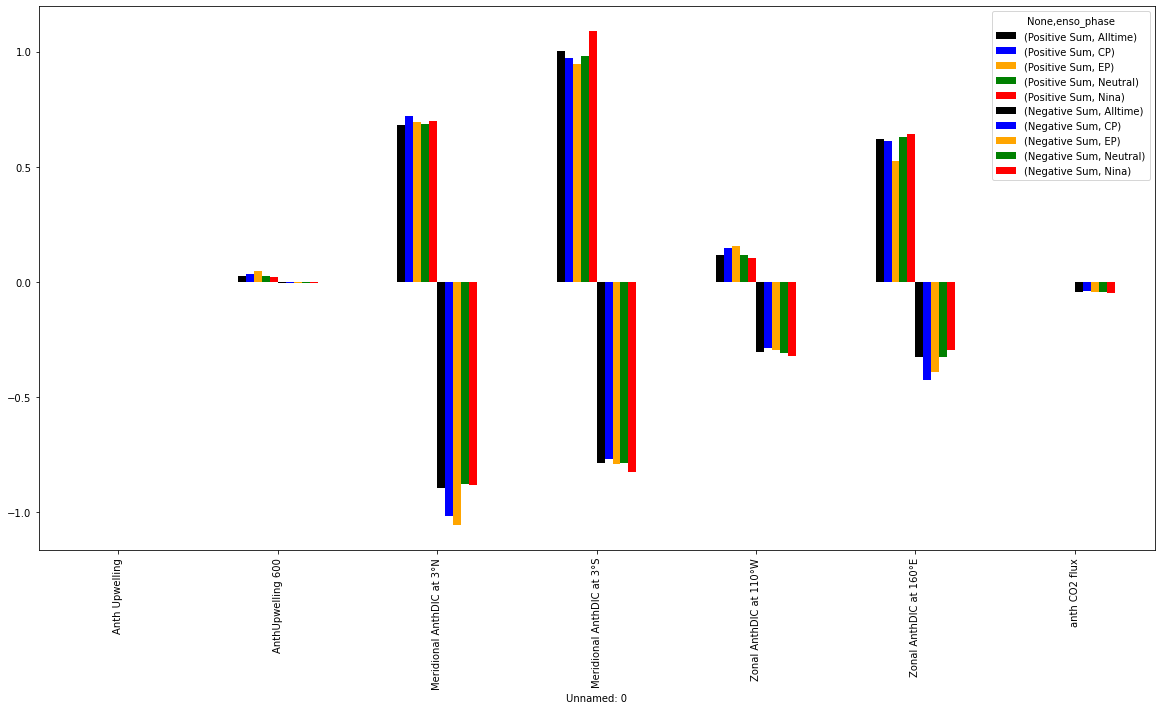

In [20]:
fig=plt.figure(figsize=(20,10))
ax=plt.subplot(111)
df=new_tx_anth[['Positive Sum','Negative Sum','enso_phase']]
df.groupby('enso_phase').sum()#
df.pivot(columns='enso_phase').plot.bar(ax=ax,color=['Black','Blue','Orange','Green','Red'])
df.pivot(columns='enso_phase')

df=new_tx_anth[['Positive Sum','Negative Sum','enso_phase']]
est=pd.DataFrame((df.pivot(columns='enso_phase')*20).sum(axis=0)).unstack(level=-1).sum()
print(est)

## RICHARDSS NUMBERS

In [ ]:
# + Collapsed="false"
import xarray as xr
#import netCDF4 as netCDF4
import numpy as np

import matplotlib.pyplot as plt
from scipy.io import netcdf
import scipy.stats as stats
import scipy.fftpack as fft
import scipy.signal as signal
import sys

#import  Cartopy
import cartopy.crs as ccrs
from cartopy import config


# + Collapsed="false"
def climatology(dsx,TIME1):
    clim = dsx.groupby(TIME1+'.month').mean(dim=TIME1)
    anom = dsx.groupby(TIME1+'.month') - clim
    season=dsx.groupby(TIME1+'.season').mean(dim=TIME1)
    return(clim,season,anom)

In [47]:
# + Collapsed="false"
#file='../big/data/csiro-dcfp-cafe-d60/ocean_month.zarr'
#file1='../big/data/csiro-dcfp-cafe-d60/ocean_ens_mean_at_analysis.zarr'
#file3='../big/data/csiro-dcfp-cafe-d60/atmos_isobaric_month.zarr'
file2='/OSM/CBR/OA_DCFP/data3/scratch_backup/06-Apr-2020/csiro-dcfp-cafe-d60/ocean_bgc_month.zarr'
file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'#'/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr'#gc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
#file1='../big/data/csiro-dcfp-cafe-d60/ocean_grid.nc'
file1='/g/data/xv83/rxm599/area.nc' #

dgrid=xr.open_dataset(file1)
dbgc = xr.open_zarr(file2,consolidated=True)

In [ ]:
ls /g/data/xv83/rxm599/

In [62]:
dbgc.adic

,Array,Chunk
Bytes,1.38 TiB,118.65 MiB
Shape,"(731, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12428 Tasks,12427 Chunks
Type,float32,numpy.ndarray


In [82]:
.area_u

<xarray.DataArray 'area_t' (yt_ocean: 300, xt_ocean: 360)>
[108000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Attributes:
    long_name:  tracer cell area
    units:      m^2
    history:    From ocean_month_1500_01

In [94]:
# + [markdown] Collapsed="false"
# ## Fluxes
file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'#'/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr'#gc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
file1='/g/data/xv83/rxm599/area.nc' #

dgrid=xr.open_dataset(file1)
dbgc = xr.open_zarr(file2,consolidated=True)


# + Collapsed="false"
stf10_mean = dbgc.stf10.mean(axis=1)
stf10_std = dbgc.stf10.std(axis=1)
stf07_mean = dbgc.stf07.mean(axis=1)
stf07_std = dbgc.stf07.std(axis=1)

# + Collapsed="false"
# q Pacific
#edic=stf07_mean.sel(yt_ocean=slice(-3,3),xt_ocean=slice(120,260)).load()
#eadic=stf10_mean.sel(yt_ocean=slice(-90,-35),xt_ocean=slice(120,260)).load()
#esum=edic*dgrid.area_t*86400*365*12E-3
#etotsd=esum.sum(axis=(1,2)).load()
#esum=eadic*dgrid.area_t*86400*365*12E-3
#etotsa=esum.sum(axis=(1,2)).load()

# model
tmp=dbgc.adic.mean(axis=1)  #.sel(ensemble=25) # Check chunks first
adic=tmp.sel(time=slice('2000-01-16','2000-12-31')).mean(axis=0)
tmp=dbgc.dic.mean(axis=1)
dic=tmp.sel(time=slice('2000-01-16','2000-12-31')).mean(axis=0)
cant=(adic-dic).load()

tmp=dbgc.adic.mean(axis=1)
adic1=tmp.sel(time=slice('2019-01-16','2019-12-31')).mean(axis=0)
tmp=dbgc.dic.mean(axis=1)
dic1=tmp.sel(time=slice('2019-01-16','2019-12-31')).mean(axis=0)
cant1=(adic1-dic1).load()


#cant=cant*

# + Collapsed="false"
mdepth=np.copy(dbgc.st_ocean)
dd=dbgc.st_ocean.copy()
dtop=mdepth*0
#dtop[49]=6000
dtop[1:50]=(mdepth[1:50]-mdepth[0:49])*.5 + mdepth[0:49]
dtop
dmx=dtop*0
dmx[0:49]=dtop[1:50]-dtop[0:49]; dmx[49]=334.7
dd=dd*0+dmx
inv=1e-3*cant*dd*dgrid.area_t
inv1=1e-3*cant1*dd*dgrid.area_t
mcinv=inv.sum(axis=0)

In [92]:
inv

<xarray.DataArray (st_ocean: 50, yt_ocean: 300, xt_ocean: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77

In [101]:
(inv.sel(xt_ocean=slice(-200,-90),st_ocean=slice(0,600),yt_ocean=slice(-3,3)).sum()*12)/1e15 #molAnthC/Cell

<xarray.DataArray ()>
array(1.54487477)

In [102]:
(inv1.sel(xt_ocean=slice(-200,-90),st_ocean=slice(0,600),yt_ocean=slice(-3,3)).sum()*12)/1e15 #molAnthC/Cell

<xarray.DataArray ()>
array(2.0255103)

In [103]:
(inv1.sel(xt_ocean=slice(-200,-90),st_ocean=slice(0,600),yt_ocean=slice(-3,3)).sum()*12)/1e15 -((inv.sel(xt_ocean=slice(-200,-90),st_ocean=slice(0,600),yt_ocean=slice(-3,3)).sum()*12)/1e15) #molAnthC/Cell)#molAnthC/Cell

<xarray.DataArray ()>
array(0.48063554)

In [77]:
2.0255103-

In [77]:
inv

<xarray.DataArray (st_ocean: 50, yt_ocean: 300, xt_ocean: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77

In [76]:
mcinv.sel(xt_ocean=slice(-200,-90),yt_ocean=slice(-20,20)).sum()#plot()#.sum()#mmol /column ###sel(xt_ocean=slice(

<xarray.DataArray ()>
array(241990.99196953)

In [59]:
mcinv.mean()

In [65]:
aflx=dbgc.stf10.sel(time=slice('1985-01-16','2015-12-31')).mean(
    axis=(0,1)).load()*86400*365*12e-3 # mmol/m2/s to g C/m2/y

In [67]:
aflx.mean()#mkdir richard_calcs

<xarray.DataArray 'stf10' ()>
array(5.27547569)

In [25]:
12e-3

0.012

In [ ]:
# + Collapsed="false"
time1=np.arange(1960.0833,2019.5,.08333)

#save some output
ddout='richard_calcs/'
#totd.to_netcdf(ddout+'totd.nc')
#tota.to_netcdf(ddout+'tota.nc')
#gstd_d.to_netcdf(ddout+'gstd_d.nc')
#gstd_a.to_netcdf(ddout+'gstd_a.nc')
#totsd.to_netcdf(ddout+'totsd.nc')
#totsa.to_netcdf(ddout+'totsa.nc')
#sstd_d.to_netcdf(ddout+'sstd_d.nc')
#sstd_a.to_netcdf(ddout+'sstd_a.nc')

# + [markdown] Collapsed="true"
# ## Flux Map

# + Collapsed="false"
#file4='/OSM/CBR/OA_DCFP/work/mat236/obs/taka_2007.nc'
#file4='/OSM/CBR/OA_DCFP/work/mat236/obs/spco2_clim_1985-2015_MPI_SOM-FFN_v2016.nc'
#dfco2=xr.open_dataset(file4)
#oflx=dfco2.fgco2_clim.mean(axis=0).load()*12  # mol/m2/y to gC/m2/y
# + Collapsed="false"
# save some output
#ddout='/scratch1/mat236/work/'
#oflx.to_netcdf(ddout+'oflx.nc')

# + Collapsed="false"
# averaged flux 
aflx=dbgc.stf10.sel(time=slice('1985-01-16','2015-12-31')).mean(
    axis=(0,1)).load()*86400*365*12e-3 # mmol/m2/s to g C/m2/y

aflx.to_netcdf(ddout+'aflx.nc')

# + [markdown] Collapsed="false"
# ## Sections

# + Collapsed="false"
#dir='bowen/data2/observations/GLODAPv2/mapped/GLODAPv2.2016b_MappedClimatologies/'
#file1='GLODAPv2.2016b.PO4.nc' 
#file2='GLODAPv2.2016b.TCO2.nc'
#file3='GLODAPv2.2016b.Cant.nc'
#dfco2=xr.open_dataset(dir+file2)
#dpo4=xr.open_dataset(dir+file1)
#daco2=xr.open_dataset(dir+file3)

#Depth=dfco2.Depth
#otco2=dfco2.TCO2.sel(lon=180.5)*1.025
#opo4 =dpo4.PO4.sel(lon=180.5)*1.025
#oaco2 =daco2.Cant.sel(lon=180.5)*1.025


# + [markdown] Collapsed="false"
# ### inventory map calculation

# + Collapsed="false"
# observations
#dx=Depth.copy()
#dx[0:31]=Depth[1:32] - Depth[0:31]; dx[32]=500
ogd=daco2.Cant#.assign_coords(depth_surface=daco2.Depth.values)
ogd=ogd.rename({'depth_surface':'depth'})
ocinv=(daco2.Cant*dx).sum(axis=0)*1.025 *1e-3  # mol/m^2
#daco2.Cant.sel(lon=180.5,lat=.5).plot()

# + Collapsed="false"
# model
tmp=dbgc.adic.mean(axis=1)
adic=tmp.sel(time=slice('2002-01-16','2002-12-31')).mean(axis=0)
tmp=dbgc.dic.mean(axis=1)
dic=tmp.sel(time=slice('2002-01-16','2002-12-31')).mean(axis=0)
cant=(adic-dic).load()


# + Collapsed="false"
mdepth=np.copy(dbgc.st_ocean)
dd=dbgc.st_ocean.copy()
dtop=mdepth*0
#dtop[49]=6000
dtop[1:50]=(mdepth[1:50]-mdepth[0:49])*.5 + mdepth[0:49]
dtop
dmx=dtop*0
dmx[0:49]=dtop[1:50]-dtop[0:49]; dmx[49]=334.7
dd=dd*0+dmx
inv=1e-3*cant*dd
mcinv=inv.sum(axis=0)

# + Collapsed="false"
#ddout='/scratch1/mat236/work/'
ocinv.to_netcdf(ddout+'oinv.nc')
cant.to_netcdf(ddout+'cant.nc')
mcinv.to_netcdf(ddout+'mcinv.nc')

# + [markdown] Collapsed="false"
# ### Pacific Section
#

# + Collapsed="false"
Depth=dfco2.Depth
otco2=dfco2.TCO2.sel(lon=180.5)*1.025
opo4 =dpo4.PO4.sel(lon=180.5)*1.025
oaco2 =daco2.Cant.sel(lon=180.5)*1.025

# + Collapsed="false"
Depth.to_netcdf(ddout+'odepth.nc')
otco2.to_netcdf(ddout+'otco2.nc')
opo4.to_netcdf(ddout+'opo4.nc')
oaco2.to_netcdf(ddout+'oaco2.nc')

# + Collapsed="false"
tmp=dbgc.adic.mean(axis=1)  # mean of the ensemble
adic=tmp.sel(time=slice('2002-01-16','2002-12-31'),
             xt_ocean=-179.5).mean(axis=0)
adic.to_netcdf(ddout+'adic.nc')

tmp=dbgc.dic.mean(axis=1)  # mean of the ensemble
dic=tmp.sel(time=slice('2002-01-16','2002-12-31'),
            xt_ocean=-179.5).mean(axis=0)
dic.to_netcdf(ddout+'dic.nc')

tmp=dbgc.no3.mean(axis=1)  # mean of the ensemble
po4=1/16.*tmp.sel(time=slice('2002-01-16','2002-12-31'),
                  xt_ocean=-179.5).mean(axis=0)
po4.to_netcdf(ddout+'po4.nc')

# + [markdown] Collapsed="false"
# # Finished !!
# ## rjm 

In [ ]:
# What is the 1.025 conversion?
# In mmol?? No pgC conversion? *86400*365*12e-3 # mmol/m2/s to g C/m2/y